In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
import innvestigate

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 1997
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

2024-04-07 14:45:29.003393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 14:45:49.049463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-07 14:45:49.224051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-07 14:45:49.226447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/rep

Running on GPU


In [2]:
### Sverdrup 
# mainDir_r4  = '/scratch2/pillarh/eccov4r4'
# mainDir_r5  = '/scratch2/pillarh/eccov4r5'
# gridDir  = mainDir_r4 + '/GRID'
# thetaDir = mainDir_r5 + '/V4r5/diags_daily/SST_day_mean'
# thetaDir_ext = mainDir_r5 + '/V4r5_ext_2020_2023_Jun/diags_daily/SST_day_mean'

## LS6
mainDir_r4 = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
mainDir_r5 = '/work/07665/shrey911/ls6/LRP_eccov4r5_data'
gridDir  = mainDir_r5 + '/GRID'
thetaDir = mainDir_r5 + '/SST_day_mean'
thetaDir_ext = mainDir_r5 + '/SST_day_mean_ext_2020_2023_Jun'

# For Sverdrup
# ds_r4 = xr.open_dataset(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')
# For LS6
ds_r4 = xr.open_dataset(mainDir_r4 + '/thetaSurfECCOv4r4.nc')

# SSH has to be kept because someone used the SSH metadata for SST, 
# It's not a bug in this code but a hack to handle an existing bug.
temp = xmitgcm.open_mdsdataset(data_dir = thetaDir,
                             grid_dir = gridDir,
                             extra_variables = dict(SSH = dict(dims=['k','j','i'],
                                                               attrs = dict(standard_name="SST",
                                                                            long_name="Sea Surface Temperature",
                                                                            units="degC"))))
temp["SST"] = temp["SSH"]
temp = temp.drop(["SSH"])
    
temp_ext = xmitgcm.open_mdsdataset(data_dir = thetaDir_ext,
                                 grid_dir = gridDir,
                                 extra_variables = dict(SST = dict(dims=['k','j','i'],
                                                                   attrs = dict(standard_name="SST",
                                                                                long_name="Sea Surface Temperature",
                                                                                units="degC"))))

ds_r5 = xr.concat([temp, temp_ext], "time")

In [3]:
ds_SST = xr.open_dataset(mainDir_r5+'/SST_all.nc')
SST = ds_SST['SST'].data

In [4]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds_r4['XC'].data
YC = ds_r4['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_XC = xr.DataArray(
    data=ds_r4['XC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="XC"),
)

da_YC = xr.DataArray(
    data=ds_r4['YC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="YC"),
)

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

wetpoints = np.nonzero(maskFinal.data)
da_wetpoints = xr.DataArray(
    data=np.asarray(wetpoints),
    dims=["wetpoints_dim", "num_wetpoints"],
    coords=dict(
        wetpoints_dim = np.arange(np.asarray(wetpoints).shape[0], dtype = int),
        num_wetpoints = np.arange(np.asarray(wetpoints).shape[1], dtype = int),
    ),
    attrs=dict(description="indices of wetpoints in the order (tile, j, i) in the three rows"),
)

da_SST = xr.DataArray(
    data=SST,
    dims=["time", "tile", "j", "i"],
    coords=dict(
        time = ds_r5['time'].data[:SST.shape[0]],
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="SST field in llc format"),
)

ds = xr.Dataset()
ds = ds.assign(XC           = da_XC,
               YC           = da_YC,
               hFacC_mask   = da_hFacC_mask,
               latMask      = da_latMask,
               maskFinal    = da_maskFinal,
               NaNmaskFinal = da_NaNmaskFinal,
               wetpoints    = da_wetpoints,
               SST          = da_SST)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r5_data/GRID/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [5]:
def anomalize_new(field, num_years = 31, first_leap_year_idx = 0):
    
    leap_yr_offsets_jan_feb   = np.array([0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8])
    leap_yr_offsets_after_feb = np.array([1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8])

    if len(field.shape) > 1:
        seasonal_trend = np.zeros((366, field.shape[1]))
    else:
        seasonal_trend = np.zeros((366,))

    #### Calculate seasonal trend
    
    # Jan 1 - Feb 28
    for d in range(59):
        same_cal_days_idx=[d+365*year+leap_yr_offsets_jan_feb[year] for year in range(num_years)]
        # Remove mean
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='constant', 
                                                        overwrite_data=False)
        # Remove linear trend
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='linear', 
                                                        overwrite_data=False)
    
    # Feb 29 starting 1996, so year 2 in 0-indexing
    same_cal_days_idx=[365*year+59+int(year/4) for year in range(first_leap_year_idx,num_years,4)]
    # Remove mean
    field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                    axis=0, 
                                                    type='constant', 
                                                    overwrite_data=False)
    # Remove linear trend
    field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                    axis=0, 
                                                    type='linear', 
                                                    overwrite_data=False)
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        same_cal_days_idx=[d-1+365*year+leap_yr_offsets_after_feb[year] for year in range(num_years)]
        # Remove mean
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='constant', 
                                                        overwrite_data=False)
        # Remove linear trend
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='linear', 
                                                        overwrite_data=False)

    return field

In [6]:
X = ds['SST'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
X = anomalize_new(X)
X_full = X.copy()
X = X[30:-30]

y = ds['SST'].isel(tile = 10, j = 1, i = 43).data.copy()
y = anomalize_new(y)
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

In [7]:
da_X = xr.DataArray(
    data=X,
    dims=["time_allData", "num_wetpoints"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data as matrix X; deseasoned, delinearized and mean removed."),
)

da_y = xr.DataArray(
    data=y,
    dims=["time_allData"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
    ),
    attrs=dict(description="All cost function y; deseasoned, delinearized and mean removed."),
)

da_X_full = xr.DataArray(
    data=X_full,
    dims=["time", "num_wetpoints"],
    coords=dict(
        time          = ds['time'],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data without accounting for conv filter as matrix X_full; deseasoned, delinearized and mean removed."),
)

da_oneHotCost = xr.DataArray(
    data=oneHotCost,
    dims=["time_allData", "NN_output_dim"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        NN_output_dim = np.array([0,1]),
    ),
    attrs=dict(description="All cost function as one-hot vector."),
)

ds = ds.assign(X          = da_X,
               y          = da_y,
               X_full     = da_X_full,
               oneHotCost = da_oneHotCost)

## Optimal Input

In [8]:
def quickSetup(X, y,
               test_split_frac,
               lagSteps,
               desired_labels,
               compute_loss,
               OI_eta,
               OI_epochs,
               OI_print_freq,
               decay_func = None,
               **NNkwargs):

    idx = int(X.shape[0]*(1-test_split_frac))
    X_train = X[:idx]
    oneHotCost_train = oneHotCost[:idx]
    X_test = X[idx:]
    oneHotCost_test = oneHotCost[idx:]

    keras.backend.clear_session()
    sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    NNkwargs['optimizer'] = sgd
    
    if lagSteps > 0:
        K = TrainFullyConnectedNN(X_train[:-lagSteps], oneHotCost_train[lagSteps:], **NNkwargs)
    elif lagSteps == 0:
        K = TrainFullyConnectedNN(X_train, oneHotCost_train, **NNkwargs)
    else:
        K = TrainFullyConnectedNN(X_train[-lagSteps:], oneHotCost_train[:lagSteps], **NNkwargs)
        
    best_model = K.quickTrain(decay_func)

    oi = OI(best_model, desired_labels, 
          compute_loss, OI_eta, OI_epochs, OI_print_freq)
    
    return oi

def compute_loss(desired_labels, pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(desired_labels, pred)

def OI(model, desired_labels_numpy, compute_loss, eta, max_iters, print_freq):
    
    inp_numpy = np.zeros((1, X.shape[1]), dtype = float)

    if len(desired_labels_numpy.shape) == 1:
        desired_labels_numpy = desired_labels_numpy[np.newaxis, :]
        
    desired_labels = tf.convert_to_tensor(desired_labels_numpy)
    print(f"Desired label : {desired_labels_numpy}")
    
    for i in range(max_iters):
        inp = tf.convert_to_tensor(inp_numpy)
        grads = GradientDescent_useGradientTape(model, inp, desired_labels, compute_loss)
        grads_numpy = np.squeeze(tf_to_numpy(grads))
        inp_numpy[0,:] = inp_numpy[0,:] - eta*grads_numpy
        if (i+1)%print_freq == 0:
            print(f"Iter {i+1}, Prediction {tf_to_numpy(model.predict(inp_numpy))}")

    optimal_input = np.zeros((13,90,90), dtype = float)
    optimal_input[wetpoints[0], wetpoints[1], wetpoints[2]] = inp_numpy[0]
    
    return optimal_input

In [9]:
Layers = [{'size': X.shape[1], 'activation': None     , 'use_bias': None},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 10.0, 'l2_b_reg': 10.0},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01},
          {'size': 2         , 'activation': 'softmax', 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01}]

Losses = [{'kind': 'categorical_crossentropy', 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 50
    lrate = initial_lrate * drop**np.floor((1+epoch)/epochs_drop)
    return lrate

OI_dict = {}
OI_eta = 0.9999
OI_epochs = 8000
OI_print_freq = 200

In [10]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')
    
    NNkwargs = {'losses': Losses, 'metrics': [metrics.categorical_accuracy],
                'batch_size': 128, 'epochs': 500, 'validation_split': 0.1,
                'filename': f'model{lagStepsList[i]}_OI', 'dirname': os.path.abspath(''),
                'random_nn_seed': 42}
    
    OI_dict[f'lag{lagStepsList[i]}'] = quickSetup(X, y, 2191.0/11323.0,
                                             lagStepsList[i],
                                             np.array([[0.0,1.0]]),
                                             compute_loss,
                                             OI_eta,
                                             OI_epochs,
                                             OI_print_freq,
                                             step_decay,
                                             layers = Layers, **NNkwargs)

Lag: -60 days, for Theta


2024-04-07 14:49:59.139284: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-07 14:49:59.141266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-07 14:49:59.143291: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
2024-04-07 14:49:59.257326: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-04-07 14:50:23.358661: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] Ten


Epoch 1: val_loss improved from inf to 1.07478, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-60_OI.h5

Epoch 2: val_loss improved from 1.07478 to 0.59324, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-60_OI.h5

Epoch 3: val_loss did not improve from 0.59324

Epoch 4: val_loss did not improve from 0.59324

Epoch 5: val_loss did not improve from 0.59324

Epoch 6: val_loss did not improve from 0.59324

Epoch 7: val_loss did not improve from 0.59324

Epoch 8: val_loss did not improve from 0.59324

Epoch 9: val_loss improved from 0.59324 to 0.51186, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-60_OI.h5

Epoch 10: val_loss did not improve from 0.51186

Epoch 11: val_loss did not improve from 0.51186

Epoch 12: val_loss did not improve from 0.51186

Epoch 13: val_loss did not improve from 0.51186

Epoch 14: val_loss did not improve from 0.51186

Epoch 15: val_loss did not improve from 0.51186

Epoch 16: val_loss did not improve

2024-04-07 16:10:46.070171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-07 16:10:46.072550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-07 16:10:46.074979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.21462, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-30_OI.h5

Epoch 2: val_loss improved from 1.21462 to 0.60202, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-30_OI.h5

Epoch 3: val_loss did not improve from 0.60202

Epoch 4: val_loss did not improve from 0.60202

Epoch 5: val_loss did not improve from 0.60202

Epoch 6: val_loss improved from 0.60202 to 0.48297, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-30_OI.h5

Epoch 7: val_loss did not improve from 0.48297

Epoch 8: val_loss did not improve from 0.48297

Epoch 9: val_loss did not improve from 0.48297

Epoch 10: val_loss did not improve from 0.48297

Epoch 11: val_loss did not improve from 0.48297

Epoch 12: val_loss did not improve from 0.48297

Epoch 13: val_loss did not improve from 0.48297

Epoch 14: val_loss did not improve from 0.48297

Epoch 15: val_loss did not improve from 0.48297

Epoch 16: val_loss did not improve

2024-04-07 17:40:18.636430: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-07 17:40:18.640298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-07 17:40:18.642987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.57169, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model0_OI.h5

Epoch 2: val_loss did not improve from 0.57169

Epoch 3: val_loss improved from 0.57169 to 0.54983, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model0_OI.h5

Epoch 4: val_loss did not improve from 0.54983

Epoch 5: val_loss did not improve from 0.54983

Epoch 6: val_loss did not improve from 0.54983

Epoch 7: val_loss improved from 0.54983 to 0.53005, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model0_OI.h5

Epoch 8: val_loss did not improve from 0.53005

Epoch 9: val_loss did not improve from 0.53005

Epoch 10: val_loss did not improve from 0.53005

Epoch 11: val_loss did not improve from 0.53005

Epoch 12: val_loss did not improve from 0.53005

Epoch 13: val_loss did not improve from 0.53005

Epoch 14: val_loss did not improve from 0.53005

Epoch 15: val_loss did not improve from 0.53005

Epoch 16: val_loss did not improve from 

2024-04-07 19:09:17.379683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-07 19:09:17.381962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-07 19:09:17.384093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.59907, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model30_OI.h5

Epoch 2: val_loss did not improve from 0.59907

Epoch 3: val_loss did not improve from 0.59907

Epoch 4: val_loss did not improve from 0.59907

Epoch 5: val_loss improved from 0.59907 to 0.54135, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model30_OI.h5

Epoch 6: val_loss did not improve from 0.54135

Epoch 7: val_loss improved from 0.54135 to 0.53108, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model30_OI.h5

Epoch 8: val_loss did not improve from 0.53108

Epoch 9: val_loss did not improve from 0.53108

Epoch 10: val_loss did not improve from 0.53108

Epoch 11: val_loss improved from 0.53108 to 0.48440, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model30_OI.h5

Epoch 12: val_loss did not improve from 0.48440

Epoch 13: val_loss did not improve from 0.48440

Epoch 14: val_loss did not improve from 0.48440

Epoch 

2024-04-07 20:37:39.792363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-07 20:37:39.794735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-07 20:37:39.796959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.67171, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model60_OI.h5

Epoch 2: val_loss did not improve from 0.67171

Epoch 3: val_loss did not improve from 0.67171

Epoch 4: val_loss improved from 0.67171 to 0.66551, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model60_OI.h5

Epoch 5: val_loss did not improve from 0.66551

Epoch 6: val_loss did not improve from 0.66551

Epoch 7: val_loss improved from 0.66551 to 0.64944, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model60_OI.h5

Epoch 8: val_loss did not improve from 0.64944

Epoch 9: val_loss improved from 0.64944 to 0.57016, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model60_OI.h5

Epoch 10: val_loss did not improve from 0.57016

Epoch 11: val_loss did not improve from 0.57016

Epoch 12: val_loss did not improve from 0.57016

Epoch 13: val_loss did not improve from 0.57016

Epoch 14: val_loss improved from 0.57016 to 0.52645, sa

2024-04-07 22:09:40.702297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-07 22:09:40.705807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-07 22:09:40.709286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.73067, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model90_OI.h5

Epoch 2: val_loss did not improve from 0.73067

Epoch 3: val_loss improved from 0.73067 to 0.65238, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model90_OI.h5

Epoch 4: val_loss did not improve from 0.65238

Epoch 5: val_loss improved from 0.65238 to 0.54991, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model90_OI.h5

Epoch 6: val_loss did not improve from 0.54991

Epoch 7: val_loss did not improve from 0.54991

Epoch 8: val_loss did not improve from 0.54991

Epoch 9: val_loss did not improve from 0.54991

Epoch 10: val_loss did not improve from 0.54991

Epoch 11: val_loss did not improve from 0.54991

Epoch 12: val_loss did not improve from 0.54991

Epoch 13: val_loss did not improve from 0.54991

Epoch 14: val_loss did not improve from 0.54991

Epoch 15: val_loss did not improve from 0.54991

Epoch 16: val_loss improved from 0.54

2024-04-07 23:44:43.495759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-07 23:44:43.509329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-07 23:44:43.512598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.97836, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model120_OI.h5

Epoch 2: val_loss did not improve from 1.97836

Epoch 3: val_loss did not improve from 1.97836

Epoch 4: val_loss did not improve from 1.97836

Epoch 5: val_loss improved from 1.97836 to 0.70694, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model120_OI.h5

Epoch 6: val_loss did not improve from 0.70694

Epoch 7: val_loss did not improve from 0.70694

Epoch 8: val_loss did not improve from 0.70694

Epoch 9: val_loss did not improve from 0.70694

Epoch 10: val_loss did not improve from 0.70694

Epoch 11: val_loss did not improve from 0.70694

Epoch 12: val_loss improved from 0.70694 to 0.66509, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model120_OI.h5

Epoch 13: val_loss did not improve from 0.66509

Epoch 14: val_loss did not improve from 0.66509

Epoch 15: val_loss did not improve from 0.66509

Epoch 16: val_loss did not improve

2024-04-08 01:18:05.362730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-08 01:18:05.365659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-08 01:18:05.369068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.90273, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model150_OI.h5

Epoch 2: val_loss did not improve from 0.90273

Epoch 3: val_loss did not improve from 0.90273

Epoch 4: val_loss improved from 0.90273 to 0.66231, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model150_OI.h5

Epoch 5: val_loss did not improve from 0.66231

Epoch 6: val_loss did not improve from 0.66231

Epoch 7: val_loss did not improve from 0.66231

Epoch 8: val_loss did not improve from 0.66231

Epoch 9: val_loss improved from 0.66231 to 0.57186, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model150_OI.h5

Epoch 10: val_loss did not improve from 0.57186

Epoch 11: val_loss did not improve from 0.57186

Epoch 12: val_loss did not improve from 0.57186

Epoch 13: val_loss did not improve from 0.57186

Epoch 14: val_loss did not improve from 0.57186

Epoch 15: val_loss did not improve from 0.57186

Epoch 16: val_loss did not improve

2024-04-08 02:49:36.928631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-08 02:49:36.931780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-08 02:49:36.934947: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.72860, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model180_OI.h5

Epoch 2: val_loss did not improve from 0.72860

Epoch 3: val_loss did not improve from 0.72860

Epoch 4: val_loss improved from 0.72860 to 0.66348, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model180_OI.h5

Epoch 5: val_loss did not improve from 0.66348

Epoch 6: val_loss improved from 0.66348 to 0.63721, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model180_OI.h5

Epoch 7: val_loss did not improve from 0.63721

Epoch 8: val_loss did not improve from 0.63721

Epoch 9: val_loss did not improve from 0.63721

Epoch 10: val_loss did not improve from 0.63721

Epoch 11: val_loss improved from 0.63721 to 0.62076, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model180_OI.h5

Epoch 12: val_loss did not improve from 0.62076

Epoch 13: val_loss did not improve from 0.62076

Epoch 14: val_loss did not improve from 0.62076

Ep

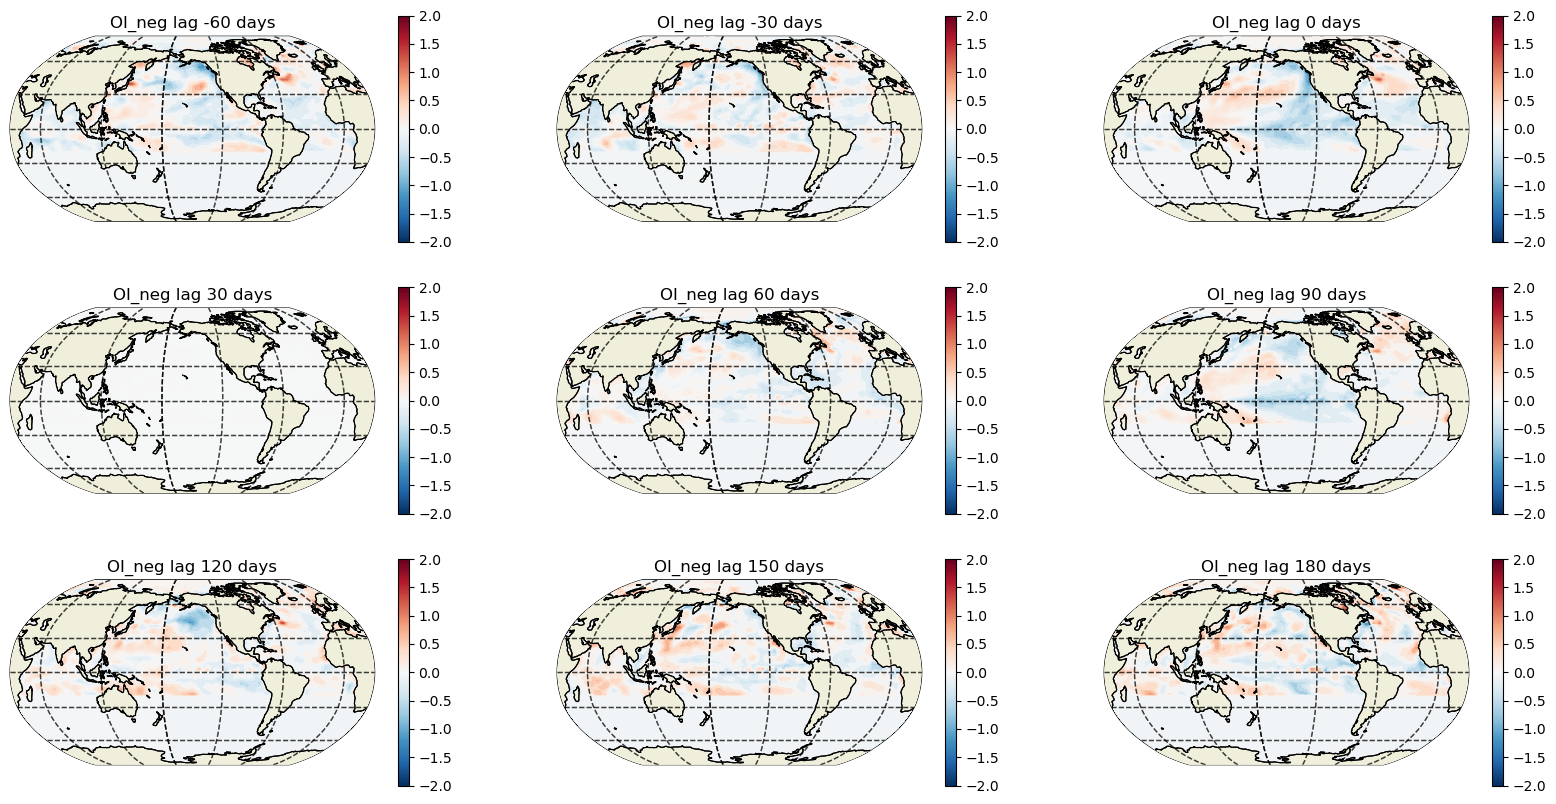

In [11]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      OI_dict[f'lag{lag}'],
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='RdBu_r', 
                                      cmin = -2, cmax = 2,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"OI_neg lag {lag} days")
    subplot_idx += 1

# plt.title("Optimal Inputs")
plt.show()

In [12]:
ds_oi = xr.Dataset()

ds_oi = ds_oi.assign(OI_minus60 = xr.DataArray(OI_dict['lag-60']),
                     OI_minus30 = xr.DataArray(OI_dict['lag-30']),
                     OI_0  = xr.DataArray(OI_dict['lag0']),
                     OI_30 = xr.DataArray(OI_dict['lag30']),
                     OI_60 = xr.DataArray(OI_dict['lag60']),
                     OI_90 = xr.DataArray(OI_dict['lag90']),
                     OI_120 = xr.DataArray(OI_dict['lag120']),
                     OI_150 = xr.DataArray(OI_dict['lag150']),
                     OI_180 = xr.DataArray(OI_dict['lag180']))

ds_oi.to_netcdf('LRP_output_forHelen/OI_v4r5_neg_newAnomalies.nc')